In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lasio # Using lasio.read() directly doesn't give full control over this specific format

In [5]:
# Read the LAS file (But had to do it as text file so we can extract data manually)
with open('dataset/Sample_Well_Data.las', 'r') as file:
    lines = file.readlines()

#Get headers
headers = lines[64].strip('# \n').split('\t')
headers = [header.strip() for header in headers]

# Find the line where data starts (line 68, index 67)
data_start_idx = 67

# Parse data lines into a list of lists
data = []
for i in range(data_start_idx, len(lines)):
    if lines[i].strip() and not lines[i].startswith('#') and not lines[i].startswith('~'):
        # Split by tabs or multiple spaces and convert to appropriate data types
        row_values = [float(val) if val.strip() else np.nan for val in lines[i].split() if val.strip()]
        if row_values:  # Only add non-empty rows
            data.append(row_values)

# Create DataFrame with headers and data
MainDF = pd.DataFrame(data, columns=headers)

# Display the first few rows of the DataFrame
print("DataFrame with headers from row 65:")
print(MainDF.head())

DataFrame with headers from row 65:
   Depth(ft)  Rate2 Of Penetration (ft/h)  Stand Pipe Pressure (psi)  \
0       23.0                        117.6                      45.19   
1       24.0                          0.0                      42.37   
2       25.0                        120.9                      49.75   
3       26.0                         98.9                      68.31   
4       27.0                        111.8                      64.84   

   Pump flow (gpm)  Bit Run (ft)  Bit Time (h)  TotalRotaryTime (h)  \
0           151.01           1.2          0.03                97.31   
1           151.01           1.6          0.04                97.33   
2           151.01           2.1          0.04                97.33   
3           151.01           2.8          0.05                97.34   
4           151.01           3.4          0.06                97.35   

   RotaryTimeOnBottom (h)  
0                    0.25  
1                    0.26  
2                   

In [9]:
print(MainDF.columns.tolist())

['Depth(ft)', 'Rate2 Of Penetration (ft/h)', 'Stand Pipe Pressure (psi)', 'Pump flow (gpm)', 'Bit Run (ft)', 'Bit Time (h)', 'TotalRotaryTime (h)', 'RotaryTimeOnBottom (h)', 'Stage']


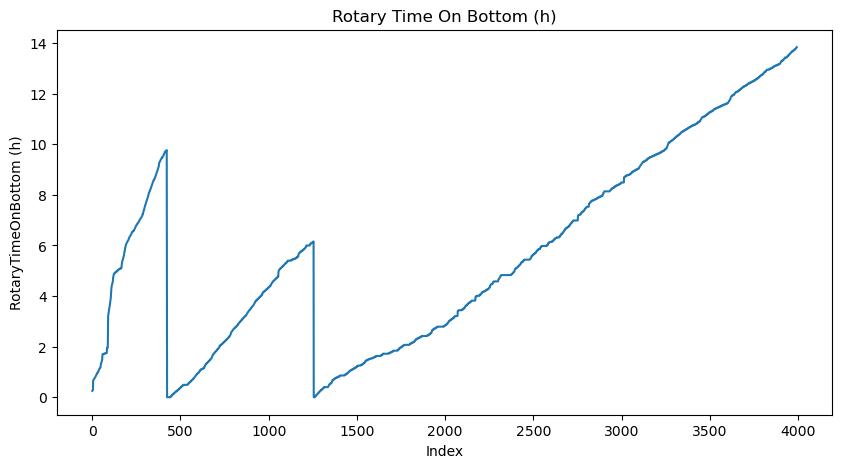

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(MainDF['RotaryTimeOnBottom (h)'])
plt.xlabel('Index')
plt.ylabel('RotaryTimeOnBottom (h)')
plt.title('Rotary Time On Bottom (h)')
plt.show()

In [12]:
# Reset Stage column
MainDF['Stage'] = "Surface"

# Find indices where RotaryTimeOnBottom hits 0
zero_indices = MainDF[MainDF['RotaryTimeOnBottom (h)'] == 0].index

if len(zero_indices) >= 2:
    # Find gaps in zero_indices to identify significant transitions
    gaps = np.where(np.diff(zero_indices) > 1)[0]
    
    if len(gaps) >= 1:
        # First significant transition marks end of Surface stage
        first_transition = zero_indices[gaps[0]]
        # Second significant transition marks start of Production stage
        second_transition = zero_indices[gaps[-1]] if len(gaps) > 1 else zero_indices[-1]
        
        # Set stages
        MainDF.loc[first_transition:second_transition-1, 'Stage'] = "Intermediate"
        MainDF.loc[second_transition:, 'Stage'] = "Production"

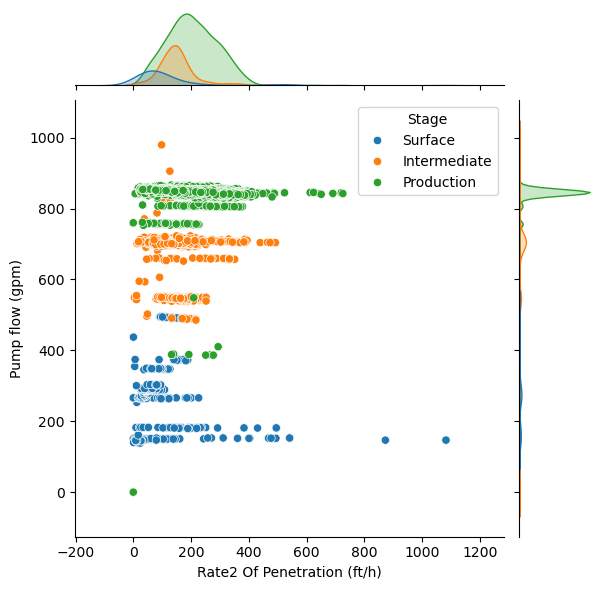

In [13]:
sns.jointplot(data=MainDF, x = 'Rate2 Of Penetration (ft/h)', y = 'Pump flow (gpm)', hue = 'Stage')